In [25]:
# Imports
import pandas as pd
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import numpy as np
from sklearn.impute import SimpleImputer

## Exercise 1

### 1.1 - Load the dataset, inspect feature names and target distribution. Comment on dataset imbalance. 

In [26]:
df = pd.read_csv('data.csv')
# Finn ut hva som menes med Feature names og target distribution, boka maybe

# Feature names
print("Feature names:", list(df.columns))


# Target distribution
print(df['diagnosis'].value_counts())
print("\nFraction:\n", df['diagnosis'].value_counts(normalize=True))

Feature names: ['id', 'diagnosis', 'radius_mean', 'texture_mean', 'perimeter_mean', 'area_mean', 'smoothness_mean', 'compactness_mean', 'concavity_mean', 'concave points_mean', 'symmetry_mean', 'fractal_dimension_mean', 'radius_se', 'texture_se', 'perimeter_se', 'area_se', 'smoothness_se', 'compactness_se', 'concavity_se', 'concave points_se', 'symmetry_se', 'fractal_dimension_se', 'radius_worst', 'texture_worst', 'perimeter_worst', 'area_worst', 'smoothness_worst', 'compactness_worst', 'concavity_worst', 'concave points_worst', 'symmetry_worst', 'fractal_dimension_worst']
diagnosis
B    357
M    212
Name: count, dtype: int64

Fraction:
 diagnosis
B    0.627417
M    0.372583
Name: proportion, dtype: float64


The dataset is a bit unbalanced, as it does have more benign than malicious data, but I think the amount of malicious data is enough. If I am unlucky the random splits might turn out with too few malicious but it should be enough.

### 1.2 - Analyze all features with and without standardization (i.e., zero mean and unit variance). Plot the feature analysis with and without standardization and decide which version is more suitable.

No Standardization
                                mean         std
radius_mean               14.127292    3.524049
texture_mean              19.289649    4.301036
perimeter_mean            91.969033   24.298981
area_mean                654.889104  351.914129
smoothness_mean            0.096360    0.014064
compactness_mean           0.104341    0.052813
concavity_mean             0.088799    0.079720
concave points_mean        0.048919    0.038803
symmetry_mean              0.181162    0.027414
fractal_dimension_mean     0.062798    0.007060
radius_se                  0.405172    0.277313
texture_se                 1.216853    0.551648
perimeter_se               2.866059    2.021855
area_se                   40.337079   45.491006
smoothness_se              0.007041    0.003003
compactness_se             0.025478    0.017908
concavity_se               0.031894    0.030186
concave points_se          0.011796    0.006170
symmetry_se                0.020542    0.008266
fractal_dimension_se

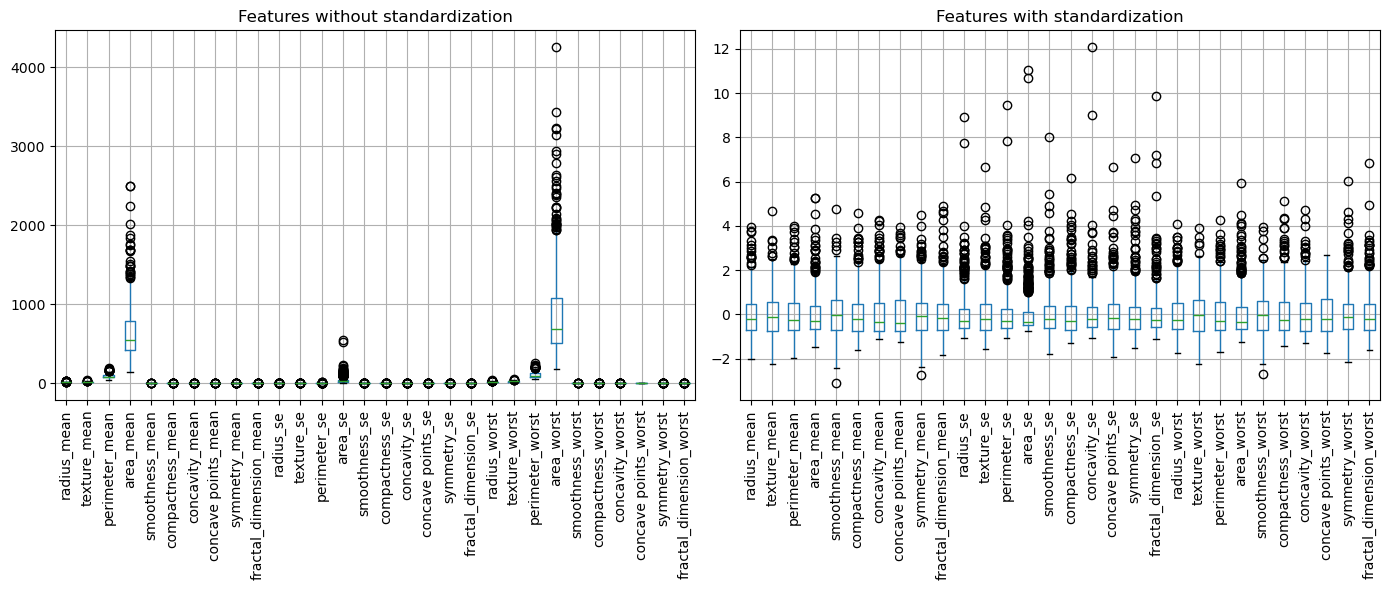

In [31]:
# 2) Velg kun features (dropp target/id)
X = df.drop(columns=["id", "diagnosis"], errors="ignore")

# 3) Standardiser
scaler = StandardScaler()
X_scaled = pd.DataFrame(scaler.fit_transform(X), columns=X.columns, index=X.index)

# 4) Beskriv statistikk før og etter
print("No Standardization\n", X.describe().T[['mean','std']])
print("\nStandardization:\n", X_scaled.describe().T[['mean','std']])

# 5) Plot boxplots for alle features
plt.figure(figsize=(14,6))

plt.subplot(1,2,1)
X.boxplot()
plt.title("Features without standardization")
plt.xticks(rotation=90)

plt.subplot(1,2,2)
X_scaled.boxplot()
plt.title("Features with standardization")
plt.xticks(rotation=90)

plt.tight_layout()
plt.show()

Looking at the plots it seems like it is best to used the standardized one, as the left plot shows that there are huge difference in scaling, where some values are in the thousands, and others are barely over zero. Using the standradized one means the scales are more comparable and therefore not having some values dominate the models